<a href="https://colab.research.google.com/github/annafumagalli/LISA-M-project/blob/master/CDAE_spectrograms_(s-chirp).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch

In [0]:
%matplotlib inline
import numpy as np
from scipy.signal import chirp
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')

import torch
from torch import nn, optim
from torch.autograd import Variable
from torchsummary import summary

import copy
import random

In [3]:
torch.cuda.get_device_name(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Datasets

Set 1: mixture of randomly generated sines and sine-gaussians within sensible parameters ranges and NO noise.

## Training

- 100 mixed signals + clean/target sources signals

In [0]:
# Parameters

n = 100 # number of training/testing datasets 

T = 60*5     # 3 min of data, sampled every 0.1 s
fs = 10
N = T*fs
t = np.linspace(0,T,N)

# These vary..

# frequency of sine wave
freq_sin = np.random.uniform(1.0, 4.0, n)
                  

# These are fixed
#sine amplitude
a = 0.8 
# Chirp frequencies
f0 = 0.5
t1 = 100.0
f1 = 1.0


In [0]:
# Time Series (needed for taking ft)

ts_s_train = np.zeros((n,N))
ts_chirp_train = np.zeros((n,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(n):
    
    ts_s_train[i,:] = a*np.sin(2*np.pi*freq_sin[i]*t) #+ noise
    ts_chirp_train[i,:] = chirp(t, f0, t1, f1, method='logarithmic') #+ noise
    
    ts_mix_train = ts_s_train + ts_chirp_train

(100, 3000)
(100, 3000)
(100, 3000)


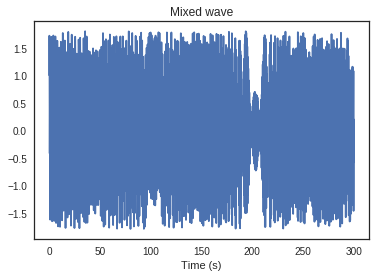

In [52]:
print(ts_s_train.shape)
print(ts_chirp_train.shape)
print (ts_mix_train.shape)

# Time series examples

#plt.plot(t, ts_s_train[0,:])
#plt.show()
#plt.plot(t, ts_chirp_train[0,:])
#plt.show()
plt.plot(t, ts_mix_train[0,:])
plt.xlabel('Time (s)')
plt.title('Mixed wave')
plt.show()

In [0]:
# Spectrograms

NFFT = 25*fs   # FTT time interval

NOVL = NFFT*0.8      # overlap

window = np.blackman(NFFT) 

spec_s_train = []
spec_chirp_train = []
spec_mix_train = []

for i in range(n):
    
    temp1, _, _ = plt.mlab.specgram(ts_s_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_s_train.append(temp1)
    
    temp2, _, _ = plt.mlab.specgram(ts_chirp_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_chirp_train.append(temp2)
    
    temp3, _, _ = plt.mlab.specgram(ts_mix_train[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_mix_train.append(temp3)

spec_s_train = np.array(spec_s_train)
spec_chirp_train = np.array(spec_chirp_train)
spec_mix_train = np.array(spec_mix_train)

# Normalise data arrays between [0, 1]

spec_s_train = (spec_s_train - spec_s_train.min())/(spec_s_train.max() - spec_s_train.min())
spec_chirp_train = (spec_chirp_train - spec_chirp_train.min())/(spec_chirp_train.max() - spec_chirp_train.min())
spec_mix_train = (spec_mix_train - spec_mix_train.min())/(spec_mix_train.max() - spec_mix_train.min())

In [49]:
spec_mix_train.shape

(100, 126, 56)

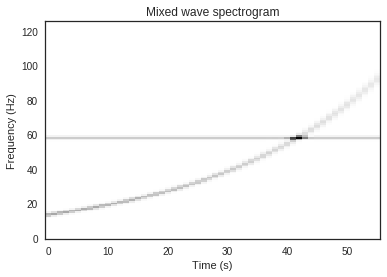

1.0 0.0


In [50]:
spec_cmap='viridis'  # colormap 

plt.imshow(spec_mix_train[2], aspect='auto', origin='lower')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Mixed wave spectrogram')

plt.show()

print(spec_mix_train.max(), spec_mix_train.min())

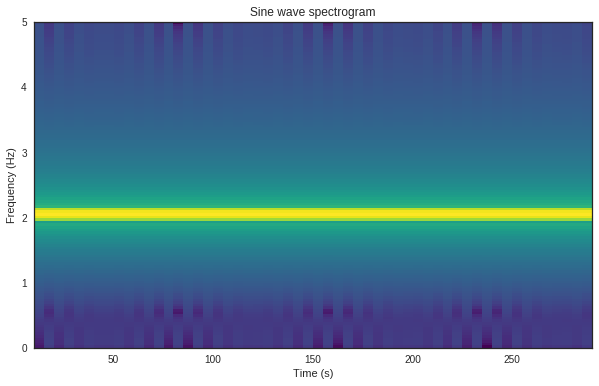

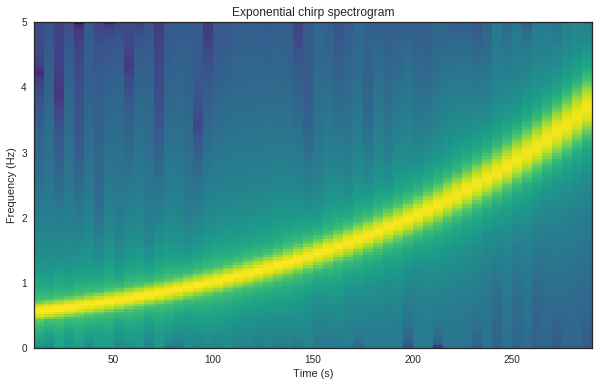

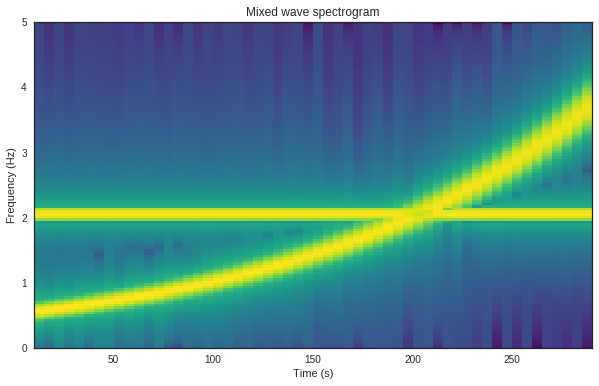

In [53]:
#Prettier spectrograms


# Plot the sine spectrogram:
plt.figure(figsize=(10,6))
spec_s, freqs_s, bins_s, im_s = plt.specgram(ts_s_train[0,:], NFFT=NFFT, Fs=fs, window=window, 
                                       noverlap=NOVL, cmap=spec_cmap)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
#plt.colorbar()
#plt.axis([0.0, T, 0.0, 2.0])
plt.title('Sine wave spectrogram')

plt.show()

# Plot the sine-gaussian spectrogram:
plt.figure(figsize=(10,6))
spec_chirp, freqs_chirp, bins_chirp, im_chirp = plt.specgram(ts_chirp_train[0,:], NFFT=NFFT, Fs=fs, window=window, 
                                       noverlap=NOVL, cmap=spec_cmap)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
#plt.colorbar()
#plt.axis([0.0, T, 0.0, 2.0])
plt.title('Exponential chirp spectrogram')

plt.show()

# Plot the mixed signal spectrogram:
plt.figure(figsize=(10,6))
spec_mix, freqs_mix, bins_mix, im_mix = plt.specgram(ts_mix_train[0,:], NFFT=NFFT, Fs=fs, window=window, 
                                       noverlap=NOVL, cmap=spec_cmap)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
#plt.colorbar()
#plt.axis([0.0, T, 0.0, 2.0])
plt.title('Mixed wave spectrogram')

plt.show()

In [54]:
freq_bins = freqs_mix.size    # spectrograms frequency bins
time_frames = bins_mix.size   # spectrograms time frames

print(freq_bins, time_frames)

126 56


## Testing

- 100 randomly generated useen mixed signals + clean/target sources for evaluation

In [0]:
# Time series (needed for taking ft)

freq_sin = np.random.uniform(1.0, 4.0, n)

ts_s_test = np.zeros((n,N))
ts_chirp_test = np.zeros((n,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(n):
    
    ts_s_test[i,:] = a*np.sin(2*np.pi*freq_sin[i]*t) #+ noise
    ts_chirp_test[i,:] = chirp(t, f0, t1, f1, method='logarithmic') #+ noise
    
    ts_mix_test = ts_s_test + ts_chirp_test

In [0]:
# Spectrograms

spec_s_test = []
spec_chirp_test = []
spec_mix_test = []

for i in range(n):
    
    temp1, _, _ = plt.mlab.specgram(ts_s_test[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_s_test.append(temp1)
    
    temp2, _, _ = plt.mlab.specgram(ts_chirp_test[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_chirp_test.append(temp2)
    
    temp3, _, _ = plt.mlab.specgram(ts_mix_test[i, :], NFFT=NFFT, Fs=fs, window=window, noverlap=NOVL)
    spec_mix_test.append(temp3)

spec_s_test = np.array(spec_s_test)
spec_chirp_test = np.array(spec_chirp_test)
spec_mix_test = np.array(spec_mix_test)

# Normalise data arrays between [0, 1]

spec_s_test = (spec_s_test - spec_s_test.min())/(spec_s_test.max() - spec_s_test.min())
spec_chirp_test = (spec_chirp_test - spec_chirp_test.min())/(spec_chirp_test.max() - spec_chirp_test.min())
spec_mix_test = (spec_mix_test - spec_mix_test.min())/(spec_mix_test.max() - spec_mix_test.min())

# Model

- Architecture is the same for each source. One net per source.
- Basically a convolutional AE
- Loss function is the mean square error between the output and the clean target.
- Weights initiated randomly

In [0]:
class CDAE(nn.Module):
    
    def __init__(self):
        super(CDAE, self).__init__()
        
        self.encoder = nn.Sequential(
            #input size: [batch_size, 1, H,W=[126,56]]
            nn.Conv2d(1, 10, kernel_size=13, stride=1, padding=6, bias=False),
            nn.Tanh(),
            # [batch_size, 10, [126,56]]
            nn.MaxPool2d(kernel_size=(3,2), stride=(3,2)),
            # [batch_size, 10, [42, 28]]
            nn.Conv2d(10, 20, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh(),
            # [batch_size, 20, [42, 28]]
            nn.MaxPool2d((3,2), (3,2)),
            # [batch_size, 20, [14,14]]
            nn.Conv2d(20, 30, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh(),
            # [batch_size, 30, [14,14]]
            nn.Conv2d(30, 40, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
            # [batch_size, 40, [14,14]]
            
        )
        
        self.decoder = nn.Sequential(
            # [batch_size, 40, [14,14]]
            nn.ConvTranspose2d(40, 30, kernel_size=(3,2), stride=(3,2), bias=False),
            nn.Tanh(),
            # [batch_size, 30, [42, 28]]
            nn.ConvTranspose2d(30, 20, kernel_size=(3,2), stride=(3,2), bias=False),
            nn.Tanh(),
            # [batch_size, 20, [126,56]]
            nn.ConvTranspose2d(20, 10, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh(),
            # [batch_size, 10, [126,56]]
            nn.ConvTranspose2d(10, 1, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Tanh()
            # [batch_size, 1, [126,56]]
        )
        
    def forward(self, x):
        
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

In [58]:
model = CDAE().to(device)

summary(model, (1, 126, 56))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 10, 126, 56]           1,690
              Tanh-2          [-1, 10, 126, 56]               0
         MaxPool2d-3           [-1, 10, 42, 28]               0
            Conv2d-4           [-1, 20, 42, 28]           1,800
              Tanh-5           [-1, 20, 42, 28]               0
         MaxPool2d-6           [-1, 20, 14, 14]               0
            Conv2d-7           [-1, 30, 14, 14]           5,400
              Tanh-8           [-1, 30, 14, 14]               0
            Conv2d-9           [-1, 40, 14, 14]          10,800
             Tanh-10           [-1, 40, 14, 14]               0
  ConvTranspose2d-11           [-1, 30, 42, 28]           7,200
             Tanh-12           [-1, 30, 42, 28]               0
  ConvTranspose2d-13          [-1, 20, 126, 56]           3,600
             Tanh-14          [-1, 20, 

# Training

In [0]:
# Hyperparameters

num_epochs = 1000
batch_size = 100
lr = 0.001

epoch 0, loss 0.007689316291362047
None


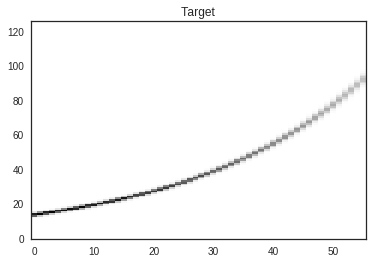

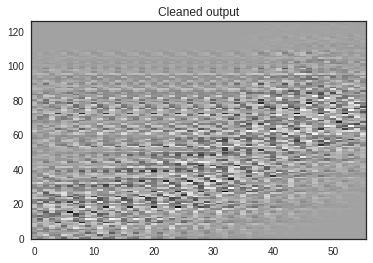

epoch 100, loss 0.00111973169259727
None


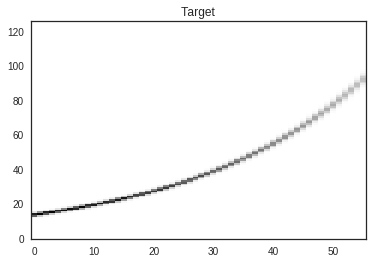

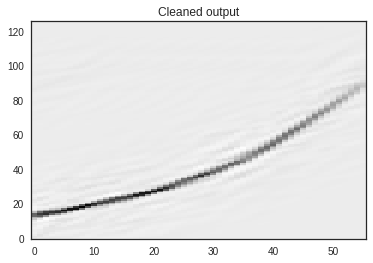

epoch 200, loss 0.00016988825518637896
None


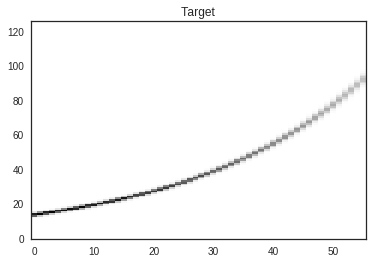

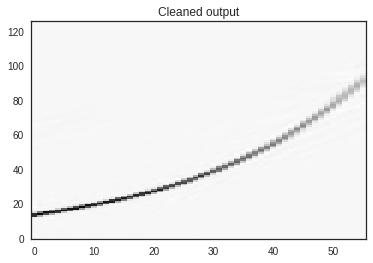

epoch 300, loss 7.241842104122043e-05
None


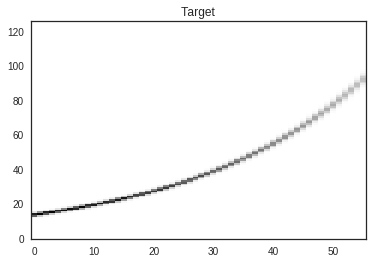

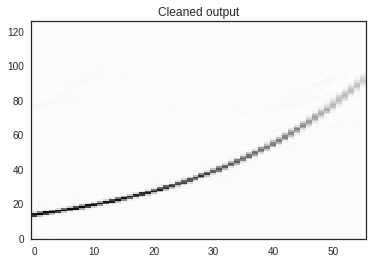

epoch 400, loss 4.328216164140031e-05
None


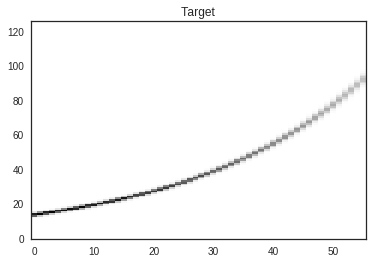

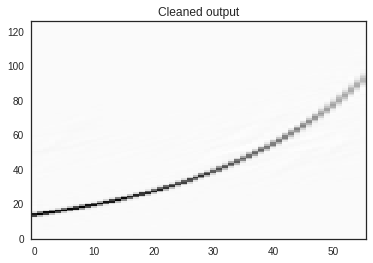

epoch 500, loss 3.324275530758314e-05
None


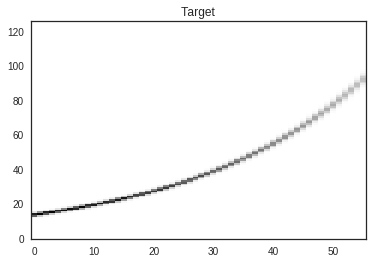

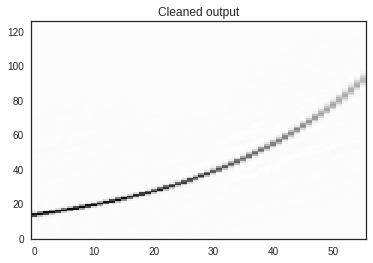

epoch 600, loss 2.797651723085437e-05
None


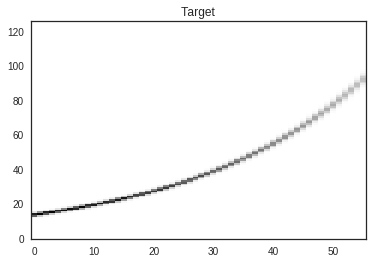

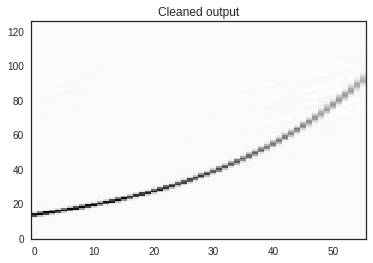

epoch 700, loss 2.4582193873357028e-05
None


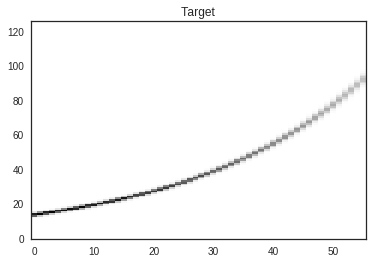

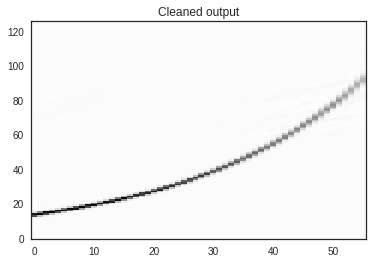

epoch 800, loss 2.2240114049054682e-05
None


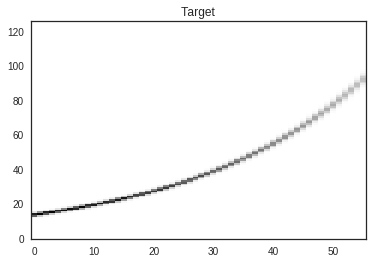

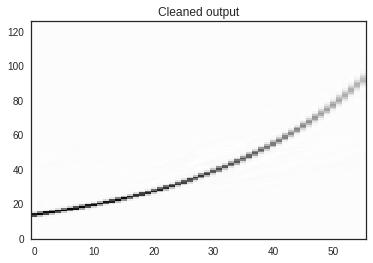

epoch 900, loss 2.082624087051954e-05
None


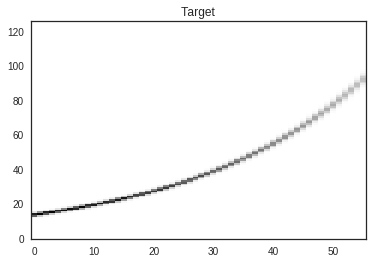

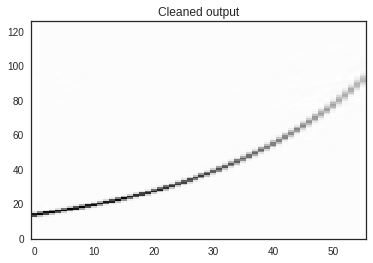

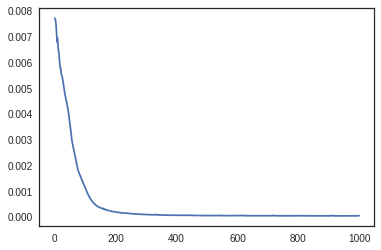

In [60]:
# This net will be trained to separate chirps from the mixed spectrograms

inputs = Variable(torch.from_numpy(spec_mix_train)).to(device)
inputs = inputs.reshape(n,1,freq_bins,time_frames)
inputs = inputs.type(torch.cuda.FloatTensor)
#inputs = inputs.type(torch.FloatTensor)

chirp_net = CDAE().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(chirp_net.parameters(), lr=lr, weight_decay=1e-5)
loss_save = []
epoch = 0

for epoch in range(num_epochs):
    
    idx  = random.sample(list(np.arange(n)),batch_size) # 50 random indices on the 100 specs 
    
    outputs = chirp_net(inputs[idx,:,:,:])
    
    clean = Variable(torch.from_numpy(spec_chirp_train)).to(device)
    clean = clean.reshape(n,1,freq_bins,time_frames)
    clean = clean.type(torch.cuda.FloatTensor)
    #clean = clean.type(torch.FloatTensor)
    
    
    loss = criterion(outputs, clean[idx,:,:,:])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_save.append(loss.item())
    
    # monitor progress
    if epoch%100==0:
        print(print('epoch {}, loss {}'.format(epoch, loss.item())))
        
        #plt.imshow(inputs[0,:,:,:].reshape(freq_bins,time_frames).cpu().numpy(),aspect='auto', origin='lower')
        #plt.title('Mixed input')
        #plt.show()
        
        plt.imshow(clean[0,:,:].reshape(freq_bins,time_frames).cpu().numpy(),aspect='auto', origin='lower')
        plt.title('Target')
        plt.show()
        
        plt.imshow(outputs[0,:,:,:].reshape(freq_bins,time_frames).detach().cpu().numpy(),aspect='auto', origin='lower')
        plt.title('Cleaned output')
        plt.show()

plt.plot(loss_save)

epoch 0, loss 0.009844264946877956
None


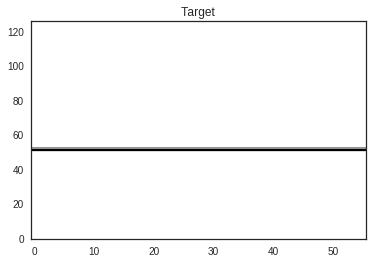

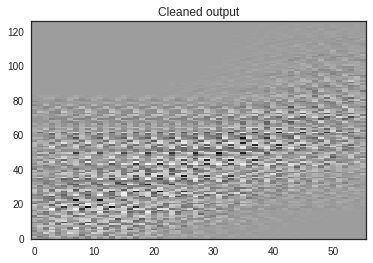

epoch 100, loss 0.001738889142870903
None


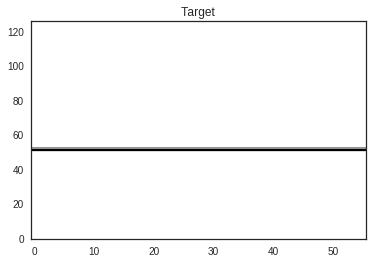

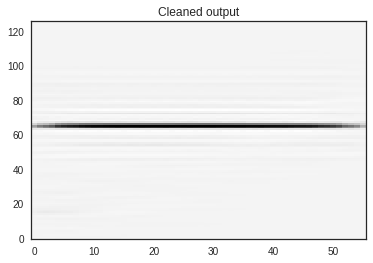

epoch 200, loss 0.0006182543584145606
None


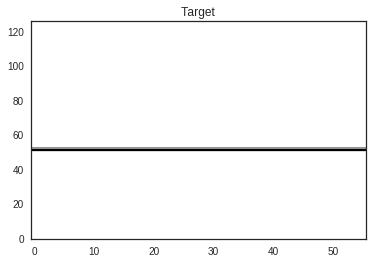

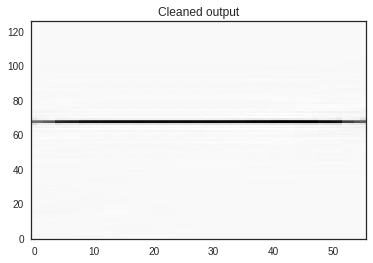

epoch 300, loss 0.00046989903785288334
None


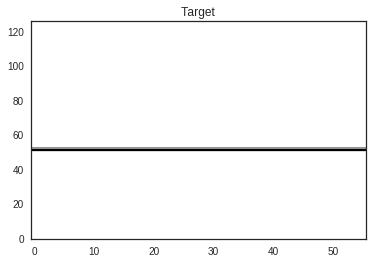

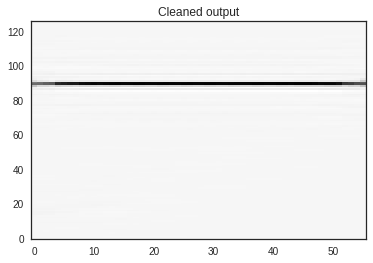

epoch 400, loss 0.00036681731580756605
None


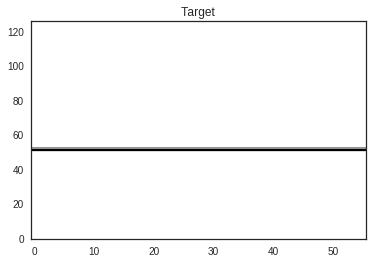

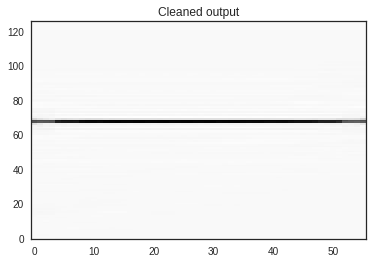

epoch 500, loss 0.0002705722290556878
None


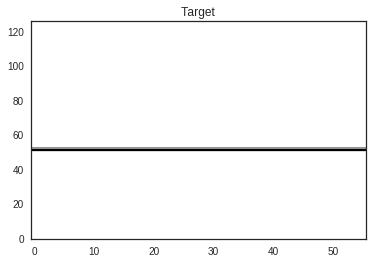

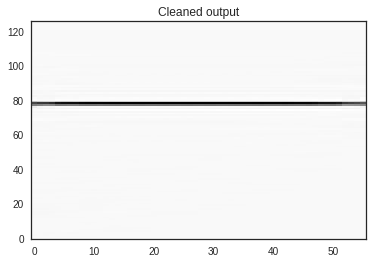

epoch 600, loss 0.00014296633889898658
None


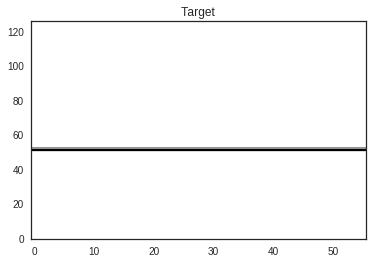

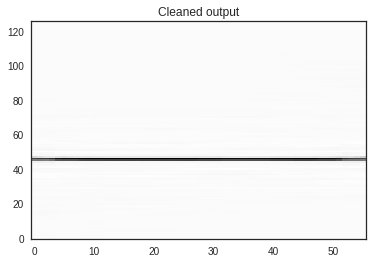

epoch 700, loss 0.00011394498869776726
None


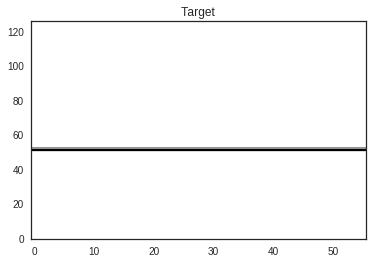

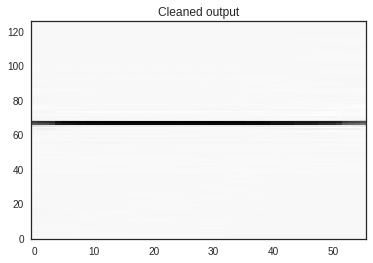

epoch 800, loss 0.00010982501407852396
None


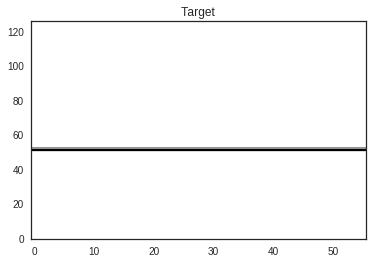

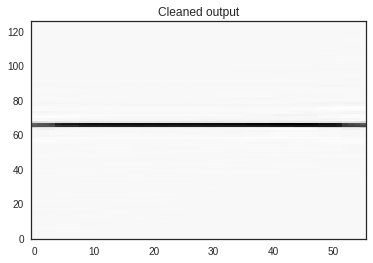

epoch 900, loss 9.215028694598004e-05
None


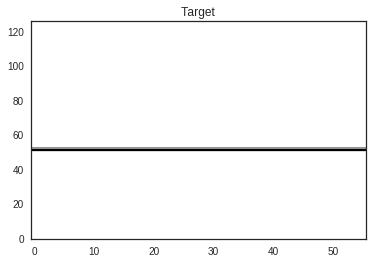

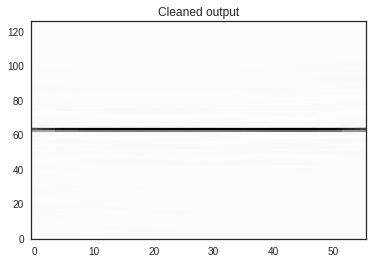

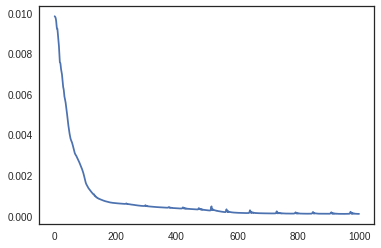

In [61]:
# This net will be trained to separate sine waves from the mixed spectrograms

inputs = Variable(torch.from_numpy(spec_mix_train)).to(device)
inputs = inputs.reshape(n,1,freq_bins,time_frames)
inputs = inputs.type(torch.cuda.FloatTensor)
#inputs = inputs.type(torch.FloatTensor)

s_net = CDAE().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(s_net.parameters(), lr=lr, weight_decay=1e-5)
loss_save = []
epoch = 0

for epoch in range(num_epochs):
    
    idx  = random.sample(list(np.arange(n)),batch_size) # 50 random indices on the 1000 specs 
    
    outputs = s_net(inputs[idx,:,:,:])
    
    clean = Variable(torch.from_numpy(spec_s_train)).to(device)
    clean = clean.reshape(n,1,freq_bins,time_frames)
    clean = clean.type(torch.cuda.FloatTensor)
    #clean = clean.type(torch.FloatTensor)
    
    
    loss = criterion(outputs, clean[idx,:,:,:])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_save.append(loss.item())
    
    # monitor progress
    if epoch%100==0:
        print(print('epoch {}, loss {}'.format(epoch, loss.item())))
        
        #plt.imshow(inputs[0,:,:,:].reshape(freq_bins,time_frames).cpu().numpy(),aspect='auto', origin='lower')
        #plt.title('Mixed input')
        #plt.show()
        
        plt.imshow(clean[0,:,:].reshape(freq_bins,time_frames).cpu().numpy(),aspect='auto', origin='lower')
        plt.title('Target')
        plt.show()
        
        plt.imshow(outputs[0,:,:,:].reshape(freq_bins,time_frames).detach().cpu().numpy(),aspect='auto', origin='lower')
        plt.title('Cleaned output')
        plt.show()


plt.plot(loss_save)

In [62]:
# Save trained nets

torch.save(s_net, './saved_models/s2_net.pt')
torch.save(chirp_net, './saved_models/chirp_net.pt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type CDAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Testing the trained models

In [0]:
# Load trained nets

chirp_net = torch.load('./saved_models/chirp_net.pt')

s_net = torch.load('./saved_models/s2_net.pt')

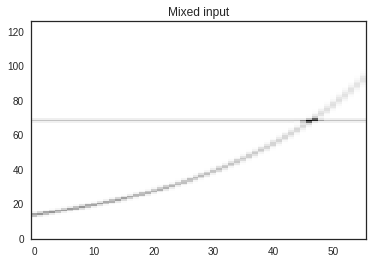

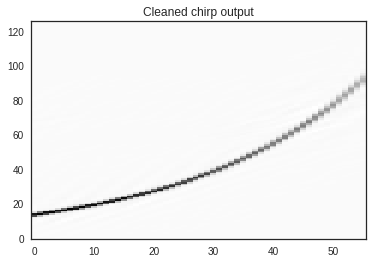

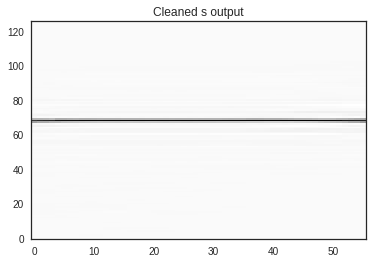

In [69]:
test_inputs = Variable(torch.from_numpy(spec_mix_test)).to(device)
test_inputs = test_inputs.reshape(n,1,1,freq_bins,time_frames)
test_inputs = test_inputs.type(torch.cuda.FloatTensor)

chirp_test_out = chirp_net(test_inputs[0,:,:,:])
s_test_out = s_net(test_inputs[0,:,:,:])



plt.imshow(spec_mix_test[0,:,:],aspect='auto', origin='lower')
plt.title('Mixed input')
plt.show()

plt.imshow(chirp_test_out.reshape(freq_bins,time_frames).detach().cpu().numpy(),aspect='auto', origin='lower')
plt.title('Cleaned chirp output')
plt.show()

plt.imshow(s_test_out.reshape(freq_bins,time_frames).detach().cpu().numpy(),aspect='auto', origin='lower')
plt.title('Cleaned s output')
plt.show()